In [1]:
!nvidia-smi

Sat Aug 20 05:25:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#Used to build and deploy Machine Learning Apps
import tensorflow as tf

#Deep Learning APIs for creating Neural Networks(Runs on Tensorflow)
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow import math
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation

# Scikit-learn : machine learning library
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Used for accessing files and file names
import pathlib 
import os

In [3]:
# Function grabs a random image from a directory
def display_random_image(dir, class_type):
    # Define directory to look in
    img_dir = dir + "/" + class_type
    
    # Get files from directory
    files = os.listdir(img_dir)
    
    # Pick a random image from that directory
    img_name = random.choice(files)
    
    # Read in the image
    img = mpimg.imread(img_dir + "/" + img_name)
    
    # Plot image with title & shape
    plt.imshow(img)
    plt.title(class_type)
    plt.axis("off");
    
    # Show the shape of the image
    print(f"Image shape: {img.shape}") 

    # So we can see how the computer sees the image
    # The image is understood as a big tensor with each pixel being
    # represented with RGB color amounts between 0 & 255
    # return img

Image shape: (2067, 2078)


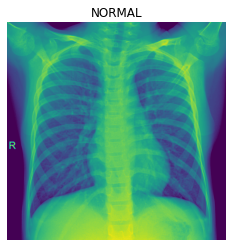

In [4]:
display_random_image("/content/drive/MyDrive/data/Pneumonia/train", "NORMAL")

Image shape: (936, 1640)


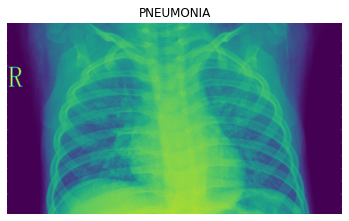

In [5]:
display_random_image("/content/drive/MyDrive/data/Pneumonia/train", "PNEUMONIA")

In [8]:
training_data = tf.keras.utils.image_dataset_from_directory(directory = "/content/drive/MyDrive/data/Pneumonia/train",
                                                            batch_size = 32, 
                                                            image_size = (256, 256),
                                                            seed = 53)
validation_data = tf.keras.utils.image_dataset_from_directory(directory = "/content/drive/MyDrive/data/Pneumonia/val",
                                                            batch_size = 16, 
                                                            image_size = (256, 256),
                                                            seed = 53)

Found 5226 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [9]:
class_names = training_data.class_names #Get class names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [10]:
# Normalize pixel values between 0 & 1
# Each pixel is currently values between 0 & 255 for RGB colors
# Neural networks work best with normalized data
# Divide all values by the max value 255
norm_layer = tf.keras.layers.Rescaling(1/255.)
training_data_norm = training_data.map(lambda x, y: (norm_layer(x), y)) # Apply the division to all data in traing data set
validation_data_norm = validation_data.map(lambda x, y: (norm_layer(x), y)) # Do same for test (validation) dataset

In [11]:
#Check for Normalization
image_batch, label_batch = next(iter(training_data_norm))
image_batch[0]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.21352252, 0.21352252, 0.21352252],
        [0.21985678, 0.21985678, 0.21985678],
        [0.23212701, 0.23212701, 0.23212701],
        ...,
        [0.15355393, 0.15355393, 0.15355393],
        [0.1414254 , 0.1414254 , 0.1414254 ],
        [0.13696769, 0.13696769, 0.13696769]],

       [[0.21690795, 0.21690795, 0.21690795],
        [0.23638558, 0.23638558, 0.23638558],
        [0.21493185, 0.21493185, 0.21493185],
        ...,
        [0.1704657 , 0.1704657 , 0.1704657 ],
        [0.1603937 , 0.1603937 , 0.1603937 ],
        [0.14804305, 0.14804305, 0.14804305]],

       [[0.2355737 , 0.2355737 , 0.2355737 ],
        [0.22426473, 0.22426473, 0.22426473],
        [0.21335402, 0.21335402, 0.21335402],
        ...,
        [0.19264707, 0.19264707, 0.19264707],
        [0.18361674, 0.18361674, 0.18361674],
        [0.17037761, 0.17037761, 0.17037761]],

       ...,

       [[0.01005285, 0.01005285, 0.01005285],
        [0.02

In [12]:
testing_data = tf.keras.utils.image_dataset_from_directory(directory = "/content/drive/MyDrive/data/Pneumonia/test",  
                                                            batch_size = 32, 
                                                            image_size = (256, 256),
                                                            seed = 53)

Found 624 files belonging to 2 classes.


In [16]:
test_data_norm = testing_data.map(lambda x, y: (norm_layer(x), y)) # Do same for test dataset

# **CNN Model**

In [13]:
#Add more Data with Augmentation to avoid Overfitting
#Increasing the amount of data by adding slightly modified versions of existing data. Images are rotated, cropped, sheared, zoomed, flipped, etc.
# Augmenting this data doesn't change the images, but instead loads here when executed
data_augmentation =  Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [14]:
tf.random.set_seed(72)
model = Sequential([
    data_augmentation,
    Conv2D(filters = 10,
           kernel_size = 3, # can also be (3, 3)
           input_shape = (256,256,3),
           activation = 'relu'), # first layer specifies input shape (height, width, colour channels)
    MaxPool2D(pool_size = 2, #or (2,2)
              padding = 'valid'), #or 'same'
    Conv2D(10, 3, activation = 'relu'), # Filters, Kernel Size, activation
    MaxPool2D(),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid') # Binary activation output layer
])
#Compile the Model 
model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
#Fit the Model
history = model.fit(training_data_norm,
                        steps_per_epoch = len(training_data_norm), #Steps through 50 batches of 32
                        epochs = 20,
                        validation_data = validation_data_norm, #Validate while fitting
                        validation_steps = len(validation_data_norm) # Steps through test data in batches of 32
                        )

Epoch 1/20
164/164 [==============================] - 1766s 11s/step - loss: 0.5255 - accuracy: 0.7622 - val_loss: 0.6428 - val_accuracy: 0.6250
Epoch 2/20
164/164 [==============================] - 33s 195ms/step - loss: 0.2938 - accuracy: 0.8752 - val_loss: 0.7203 - val_accuracy: 0.8125
Epoch 3/20
164/164 [==============================] - 32s 188ms/step - loss: 0.2482 - accuracy: 0.8976 - val_loss: 0.6954 - val_accuracy: 0.7500
Epoch 4/20
164/164 [==============================] - 34s 197ms/step - loss: 0.2425 - accuracy: 0.8986 - val_loss: 0.9440 - val_accuracy: 0.5625
Epoch 5/20
164/164 [==============================] - 32s 187ms/step - loss: 0.2085 - accuracy: 0.9108 - val_loss: 0.7725 - val_accuracy: 0.7500
Epoch 6/20
164/164 [==============================] - 32s 188ms/step - loss: 0.1933 - accuracy: 0.9215 - val_loss: 0.8772 - val_accuracy: 0.7500
Epoch 7/20
164/164 [==============================] - 34s 198ms/step - loss: 0.1824 - accuracy: 0.9250 - val_loss: 0.9899 - val_ac

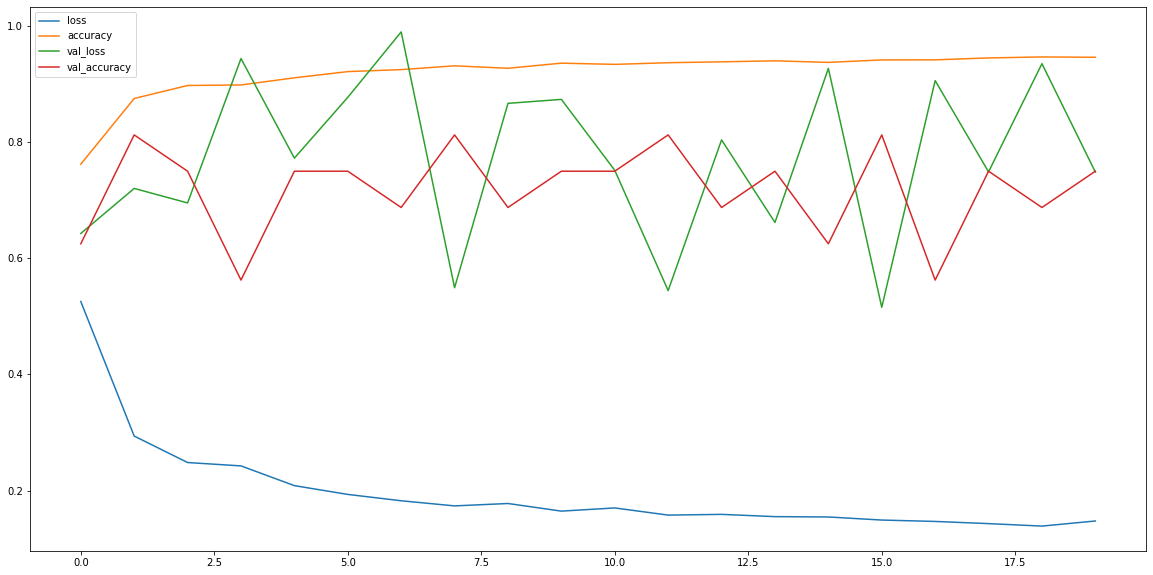

In [15]:
pd.DataFrame(history.history).plot(figsize = (20,10)) #Plot models training curves

In [17]:
model.evaluate(test_data_norm)

20/20 [==============================] - 247s 7s/step - loss: 0.3966 - accuracy: 0.8301


[0.39656007289886475, 0.8301281929016113]

In [18]:
model.save("Pneumonia_Detection_CNN")

# **ResNet Feature Model**

In [20]:
import tensorflow_hub as hub # Provides pretrained models

In [25]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
# Download ResNet model and save as Keras layer
# Trainable : False means we don't want to train it further
resnet_layer = hub.KerasLayer(resnet_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
resnet_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    resnet_layer,
    # Define we will use 2 classes
    Dense(1,
        activation="sigmoid")
])

In [27]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [26]:
# Compile resnet Model
resnet_model.compile(loss="binary_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [28]:
# Fit Transfer Learning Model
resnet_history = resnet_model.fit(training_data_norm,
                                epochs=5,
                                steps_per_epoch=len(training_data_norm),
                                validation_data=validation_data_norm)

Epoch 1/5
164/164 [==============================] - 43s 220ms/step - loss: 0.1725 - accuracy: 0.9349 - val_loss: 0.2514 - val_accuracy: 0.9375
Epoch 2/5
164/164 [==============================] - 37s 211ms/step - loss: 0.1008 - accuracy: 0.9646 - val_loss: 0.3357 - val_accuracy: 0.8750
Epoch 3/5
164/164 [==============================] - 36s 208ms/step - loss: 0.0804 - accuracy: 0.9705 - val_loss: 0.3069 - val_accuracy: 0.9375
Epoch 4/5
164/164 [==============================] - 36s 208ms/step - loss: 0.0693 - accuracy: 0.9767 - val_loss: 0.2957 - val_accuracy: 0.9375
Epoch 5/5
164/164 [==============================] - 35s 203ms/step - loss: 0.0615 - accuracy: 0.9788 - val_loss: 0.2866 - val_accuracy: 0.9375


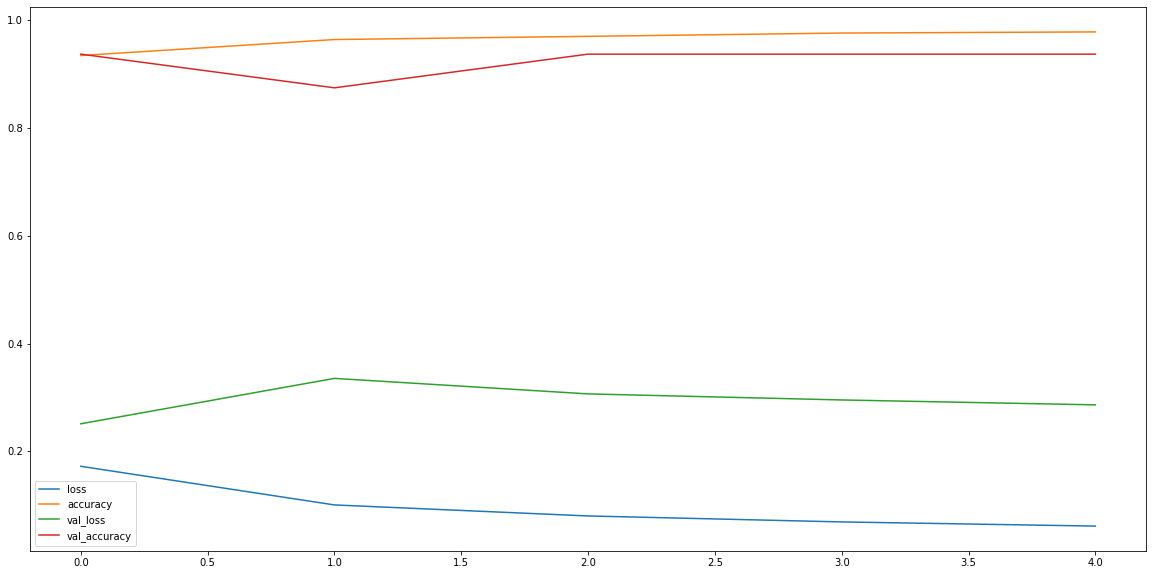

In [34]:
pd.DataFrame(resnet_history.history).plot(figsize = (20,10)) #Plot models training curves

In [29]:
resnet_model.evaluate(test_data_norm)

20/20 [==============================] - 4s 146ms/step - loss: 0.4431 - accuracy: 0.8413


[0.44311121106147766, 0.8413461446762085]

# **Efficient Net Feature Model**

In [30]:
eff_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
# Download EfficientNet model and save as Keras layer
# Trainable : False means we don't want to train it further
eff_layer = hub.KerasLayer(eff_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
eff_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    eff_layer,
    # Define we will use 2 classes
    Dense(1,
        activation="sigmoid")
])


In [31]:
# Compile EfficientNet Model
eff_model.compile(loss="binary_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [32]:
# Fit Transfer Learning Model
eff_history = eff_model.fit(training_data_norm,
                                epochs=5,
                                steps_per_epoch=len(training_data_norm),
                                validation_data=validation_data_norm)

Epoch 1/5
164/164 [==============================] - 118s 505ms/step - loss: 0.2193 - accuracy: 0.9164 - val_loss: 0.1943 - val_accuracy: 0.9375
Epoch 2/5
164/164 [==============================] - 79s 469ms/step - loss: 0.1259 - accuracy: 0.9564 - val_loss: 0.1705 - val_accuracy: 0.9375
Epoch 3/5
164/164 [==============================] - 78s 468ms/step - loss: 0.1054 - accuracy: 0.9642 - val_loss: 0.1334 - val_accuracy: 0.9375
Epoch 4/5
164/164 [==============================] - 78s 468ms/step - loss: 0.0951 - accuracy: 0.9661 - val_loss: 0.1436 - val_accuracy: 0.9375
Epoch 5/5
164/164 [==============================] - 78s 469ms/step - loss: 0.0870 - accuracy: 0.9692 - val_loss: 0.1432 - val_accuracy: 0.9375


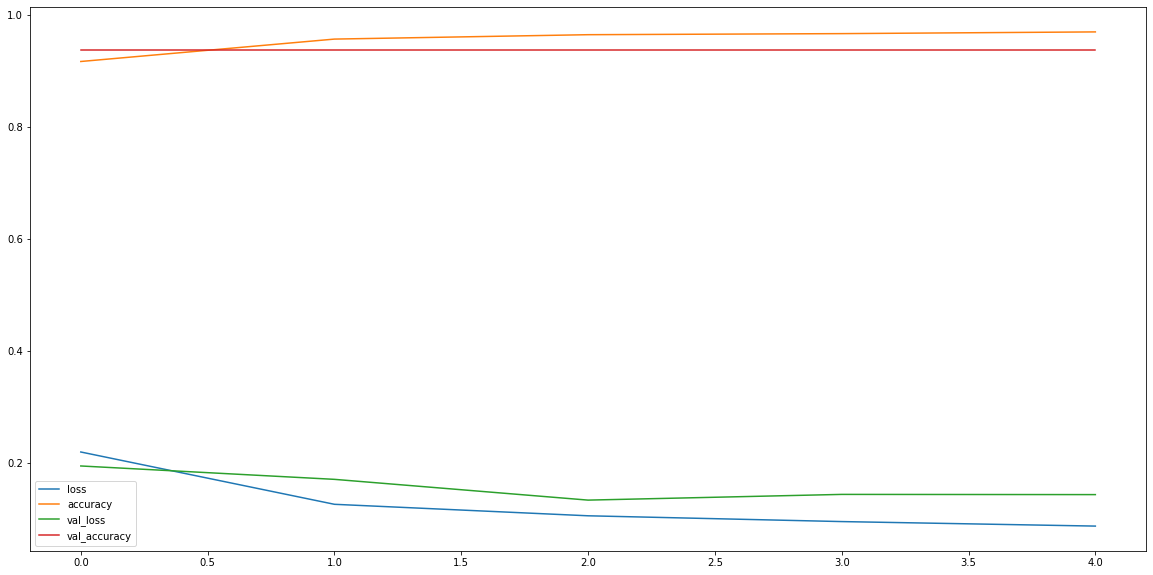

In [35]:
pd.DataFrame(eff_history.history).plot(figsize = (20,10)) #Plot models training curves

In [33]:
eff_model.evaluate(test_data_norm)

20/20 [==============================] - 10s 447ms/step - loss: 0.4681 - accuracy: 0.8221


[0.4680902063846588, 0.8221153616905212]